# Tokenizer ):

## Overview

* [Introduction](#intro)
    * [Unicode Code Points](#code-points)
    * [UTF-8](#utf-8)
    * [Bytes](#bytes)
    * [Other encoding types](#other-encodings)
* [Byte Pair Encoding](#bpe)
    * [`get_stats`](#get_stats)
    * [`merge`](#merge)
* [Putting it all together](#together)
* [Tokenizer](#tokenizer)
    * [Decoding](#decoding)
    * [Encoding](#encoding)
        * [Fancy code explanation](#fancy)
* [Forced splits using regex patterns (GPT Series)](#forced_splits)
    * [How do numbers get captured by the regex pattern?](#numbers)
    * [How do apostrophes get captured by the regex pattern?](#apostrophes)
    * [How do punctuations get captured by the regex pattern?](#punctuations)
    * [How do unecessary whitespaces get captured by the regex pattern?](#whitespaces)
    * [Example: Python code](#example-python)
* [Tiktoken](#tiktoken)
* [Special Tokens](#special-tokens)
* [Exercise](#exercise)
* [sentencepiece](#sentencepiece)
    * [`byte_fallback`](#byte-fallback)
    * [`add_dummy_prefix`](#add-dummy-prefix)
    * [Llama 2 tokenizer proto](#llama-2-tokenizer-proto)
    * [`vocab_size`](#vocab-size)
* [Extension of `vocab_size`](#extension)
* [Learning to Compress Prompts with Gist Tokens](#gist-tokens)
* [Multimodality](#multimodality)
* [Revisiting and explaining the quirks of LLM tokenization](#revisiting-and-explaining-the-quirks-of-llm-tokenization)
    * [Why can't LLM spell words?](#why-cant-llm-spell-words)
    * [Why is LLM worse at non-English languages (e.g. Japanese)?](#why-is-llm-worse-at-non-english-languages)
    * [Why is LLM bad at simple arithmetic?](#why-is-llm-bad-at-simple-arithmetic)
    * [Why did GPT-2 have more than necessary trouble coding in Python?](#why-did-gpt-2-have-more-than-necessary-trouble-coding-in-python)
    * [Why did my LLM abruptly halt when it sees the string "<|endoftext|>"?](#why-did-my-llm-abruptly-halt-when-it-sees-the-string-end-of-text)
    * [What is this weird warning I get about a "trailing whitespace"?](#what-is-this-weird-warning-i-get-about-a-trailing-whitespace)
    * [Why the LLM break if I ask it about "SolidGoldMagikarp"?](#why-the-llm-break-if-i-ask-it-about-solidgoldmagikarp)
    * [Why should I prefer to use YAML over JSON with LLMs?](#why-should-i-prefer-to-use-yaml-over-json-with-llms)

Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

- [Why can't LLM spell words?](why-cant-llm-spell-words) **Tokenization**.
- Why can't LLM do super simple string processing tasks like reversing a string? **Tokenization**.
- [Why is LLM worse at non-English languages (e.g. Japanese)?](#why-is-llm-worse-at-non-english-languages) **Tokenization**.
- [Why is LLM bad at simple arithmetic?](#why-is-llm-bad-at-simple-arithmetic) **Tokenization**.
- [Why did GPT-2 have more than necessary trouble coding in Python?](#why-did-gpt-2-have-more-than-necessary-trouble-coding-in-python) **Tokenization**.
- [Why did my LLM abruptly halt when it sees the string "<|endoftext|>"?](#why-did-my-llm-abruptly-halt-when-it-sees-the-string-end-of-text) **Tokenization**.
- [What is this weird warning I get about a "trailing whitespace"?](#what-is-this-weird-warning-i-get-about-a-trailing-whitespace) **Tokenization**.
- [Why the LLM break if I ask it about "SolidGoldMagikarp"?](#why-the-llm-break-if-i-ask-it-about-solidgoldmagikarp) **Tokenization**.
- [Why should I prefer to use YAML over JSON with LLMs?](#why-should-i-prefer-to-use-yaml-over-json-with-llms) **Tokenization**.
- Why is LLM not actually end-to-end language modeling? **Tokenization**.
- What is the real root of suffering? **Tokenization**.

After we go through this notebook, at the end, we will [revisit these questions](#revisiting-and-explaining-the-quirks-of-llm-tokenization) again.
 
---

Good tokenization web app: https://tiktokenizer.vercel.app

Example string:

```
Tokenization is at the heart of much weirdness of LLMs. Do not brush it off.

127 + 677 = 804
1275 + 6773 = 8041

Egg.
I have an Egg.
egg.
EGG.

만나서 반가워요. 저는 OpenAI에서 개발한 대규모 언어 모델인 ChatGPT입니다. 궁금한 것이 있으시면 무엇이든 물어보세요.

for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
```

---

Much glory awaits someone who can delete the need for tokenization. But meanwhile, let's learn about it.


## Introduction <a id="intro"></a>

Strings are immutable sequences of Unicode code points. See [here](https://docs.python.org/3/library/stdtypes.html#:~:text=Strings%20are%20immutable%20sequences%20of%20Unicode%20code%20points.) for more information.

In [ ]:
"안녕하세요 👋 (hello in Korean!)"

### Unicode Code Points <a id="code-points"></a>

Let's see the Unicode code point for each character. The Unicode code points are numbers assigned by the Unicode Consortium to every character in every writing system.

In [ ]:
# `ord` function only takes in a character
print([ord(x) for x in "안녕하세요 👋 (hello in Korean!)"])

### UTF-8 <a id="utf-8"></a>

The raw code points are already integers, so why can't we simply use these integers and not have any tokenization at all? One reason for that is that the vocabulary would be quite long. For Unicodes, there will be a vocabulary size of about [150,000 different code points](https://en.wikipedia.org/wiki/Unicode#:~:text=%5BA%5D%20defines-,149813%20characters,-%5B3%5D%20and). However, more worryingly than that is the Unicode standard is very much alive and keeps changing. Therefore, it's not necessarily a stable representation that we may want to use directly.

For those reasons, we need something better and we turn to encodings. The Unicode Consortium defines [three types of encodings](https://en.wikipedia.org/wiki/Unicode#:~:text=The%20Unicode%20Standard%20itself%20defines%20three%20encodings%3A%20UTF%2D8%2C%20UTF%2D16%2C%20and%20UTF%2D32): UTF-8, UTF-16, and UTF-32. We will use UTF-8 for this tutorial. **These encodings are the ways which we can take Unicode text and translate into binary data or byte streams.** UTF-8 is by far the most common encoding.

UTF-8 takes every single Unicode code point and translates it into byte streams and these are between 1 and 4 bytes.
Let's encode the string above into UTF-8.

In [ ]:
# Encode string into UTF-8
print(list("안녕하세요 👋 (hello in Korean!)".encode("utf-8")))

### Bytes <a id="bytes"></a>

The output from above contains integers which are the representation of their corresponding bytes. Let's see how we can view the output above as a byte stream.

In [ ]:
# View the raw bytes
print(
    "안녕하세요 👋 (hello in Korean!)".encode("utf-8")
)  # you can use the `bytes` function too

### Other encoding types <a id="other-encodings"></a>

We can even encode the text in UTF-16.

In [ ]:
# Encode string into UTF-16
print(list("안녕하세요 👋 (hello in Korean!)".encode("utf-16")))

Here, we can see a disadvantage of UTF-16. We see that there are many instances where there is a zero followed another integer. Therefore, we can get a sense that this is a bit of a wasteful encoding. You can run the same code above with UTF-32 and you will get a sense of the wastefulness of encoding with UTF-16 or UTF-32.

In [ ]:
# Try with UTF-32 encoding here

Suffice to say, we would like to stick with UTF-8 encoding. However, if we use UTF-8 naively (which are byte streams), this would imply a vocabulary length of only 256 possible tokens (1 byte = 8 bits = $2^{8}$ = 256) This vocabulary size is very very small. What this is going to do if we were to use this naively is that all our text would be stretched out over very very long sequences of bytes. What this does is the embedding table is going to be very tiny (as well as the prediction at the top, the final layer is also going to be tiny) but our sequences are very long. Additionally, we have a finite context length (for computational reasons) in the attention that can be supported in the transformer architecture. 

Finite context lengths and very long sequences is inefficient and is not going to allow the attention to attend to tokens before in sufficiently long text for the purpose of next token prediction task. Therefore, we don't want to use the raw bytes of UTF-8 encoding. We want to support larger vocabulary size that we can tune as a hyperparameter and also stick to the UTF-8 encoding. What do we do? What

Byte pair encoding!

## Byte Pair Encoding <a id="bpe"></a>

The byte pair encoding (BPE) algorithm allows us to compress these byte sequences to a variable amount (which we'll get to this in a bit). The BPE algorithm is not all that complicated and the [Wikepedia page](https://en.wikipedia.org/wiki/Byte_pair_encoding) is actually quite instructive as far as the basic idea goes.

Let's code it out with some sample text!

In [ ]:
# Text from https://www.reedbeta.com/blog/programmers-intro-to-Unicode/
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."

tokens = text.encode("utf-8")  # raw bytes
tokens = list(
    map(int, tokens)
)  # convert to a list of integers in range 0..255 for convenience

print("---")
print(text)
print("length:", len(text))
print("---")
print(tokens)
print("length:", len(tokens))

We can see that the length of the raw bytes is more than the length of the text. This is because for simple words, the UTF-8 encoding result in a single integer. But for complex characters (like in the beginning of the text) can result in multiple bytes (i.e. two to four bytes).

Now, for the first step of the algorithm, what we'd like to do is to find the most commonly occurring pair of bytes. Then, we're going to merge it.

### `get_stats` <a id="get_stats"></a>

This function iterates through the sequence and counts the occurences of each pair. Results are stored in a dictionary.

In [ ]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):  # Pythonic way to iterate consecutive elements
        counts[pair] = counts.get(pair, 0) + 1

    return counts


stats = get_stats(tokens)
print(stats)

Let's reformat the dictionary into a list of tuples where the first item in the tuples represent the counts and the second item in the tuples represent the pairs. This list of tuples are also sorted such that the most common pair is first in the list.

In [ ]:
print(sorted(((v, k) for k, v in stats.items()), reverse=True))

It looks like (100, 32) is the most commonly occurring pair and it occurred 20 times. To see what this pair represents, we can decode it using `chr`. 

In [ ]:
chr(101), chr(32)

This means in our original text, there were a lot of e's followed by spaces.

Now that we've identified the most common pair, we would like to iterate over the sequence and mint a new token for every one of the token pair (the most common pair) above. This new token will have the new token ID of 256 because the sequence has IDs going from 0 to 255 (256 integers).

Using the (101, 32) pair as an example, whenever we see a (101, 32) pair while iterating through the sequence, we will "swap it out" (or merge it) with a new token, 256. Let's implement this!

### `merge` <a id="merge"></a>

This function merges the most common pair into a newly minted token. We will store these merge rules in a dictionary.

In [ ]:
# Get the most common pair from the `stats` dictionary
top_pair = max(stats, key=stats.get)
print(top_pair)

In [ ]:
def merge(ids, pair, idx):
    # In the list of ints (ids), replace all consecutive
    # occurences of pair with the new token id
    newids = []
    i = 0
    while i < len(ids):
        # If we are not at the very last position AND the pair matches,
        # replace it with the new token id
        if (i < len(ids) - 1) and (ids[i] == pair[0] and ids[i + 1] == pair[1]):
            newids.append(idx)
            i += 2
        else:
            newids.append(ids[i])
            i += 1

    return newids


# Example
print(merge([5, 6, 6, 7, 9, 1], (6, 7), 99))

In [ ]:
tokens2 = merge(tokens, top_pair, 256)

print("length:", len(tokens2))
print(tokens2)

Previously, we had a token length of 616. After the first iteration of the BPE algorithm, we now have a token length of 596. This makes sense as we had 20 counts for our `top_pair`,  (101, 32) which has now been replaced with the new token 256. 

**Tip:** `Ctrl + F` to search for token "256" and you will see 20 of them. Do the same and search for tokens "101, 32" and you will not find any consecutive pairs. Do note that tokens 101 or 32 can still occur separately.

Now, we can write a function to iterate this! The high level steps are as follow:

1. Go over the sequence
2. Find the most commmon pair
3. Merge it
4. Repeat (hyperparameter)

How many times do we iterate for? It is totally up to us as a hyperparameter. The more merges we do, the larger our vocabulary size will become and the shorter our sequence length will be. There is some sweet spot that we will usually find that works the best in practice. As an example, GPT-4 currently uses a vocabulary size of roughly 100,000 tokens.

## Putting it all together <a id="together"></a>

In [ ]:
# Making the training text longer to have more representative token statistics
# text from https://www.reedbeta.com/blog/programmers-intro-to-Unicode/
text = """A Programmer’s Introduction to Unicode March 3, 2017 · Coding · 22 Comments  Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺\u200c🇳\u200c🇮\u200c🇨\u200c🇴\u200c🇩\u200c🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception.  A few months ago, I got interested in Unicode and decided to spend some time learning more about it in detail. In this article, I’ll give an introduction to it from a programmer’s point of view.  I’m going to focus on the character set and what’s involved in working with strings and files of Unicode text. However, in this article I’m not going to talk about fonts, text layout/shaping/rendering, or localization in detail—those are separate issues, beyond my scope (and knowledge) here.  Diversity and Inherent Complexity The Unicode Codespace Codespace Allocation Scripts Usage Frequency Encodings UTF-8 UTF-16 Combining Marks Canonical Equivalence Normalization Forms Grapheme Clusters And More… Diversity and Inherent Complexity As soon as you start to study Unicode, it becomes clear that it represents a large jump in complexity over character sets like ASCII that you may be more familiar with. It’s not just that Unicode contains a much larger number of characters, although that’s part of it. Unicode also has a great deal of internal structure, features, and special cases, making it much more than what one might expect a mere “character set” to be. We’ll see some of that later in this article.  When confronting all this complexity, especially as an engineer, it’s hard not to find oneself asking, “Why do we need all this? Is this really necessary? Couldn’t it be simplified?”  However, Unicode aims to faithfully represent the entire world’s writing systems. The Unicode Consortium’s stated goal is “enabling people around the world to use computers in any language”. And as you might imagine, the diversity of written languages is immense! To date, Unicode supports 135 different scripts, covering some 1100 languages, and there’s still a long tail of over 100 unsupported scripts, both modern and historical, which people are still working to add.  Given this enormous diversity, it’s inevitable that representing it is a complicated project. Unicode embraces that diversity, and accepts the complexity inherent in its mission to include all human writing systems. It doesn’t make a lot of trade-offs in the name of simplification, and it makes exceptions to its own rules where necessary to further its mission.  Moreover, Unicode is committed not just to supporting texts in any single language, but also to letting multiple languages coexist within one text—which introduces even more complexity.  Most programming languages have libraries available to handle the gory low-level details of text manipulation, but as a programmer, you’ll still need to know about certain Unicode features in order to know when and how to apply them. It may take some time to wrap your head around it all, but don’t be discouraged—think about the billions of people for whom your software will be more accessible through supporting text in their language. Embrace the complexity!  The Unicode Codespace Let’s start with some general orientation. The basic elements of Unicode—its “characters”, although that term isn’t quite right—are called code points. Code points are identified by number, customarily written in hexadecimal with the prefix “U+”, such as U+0041 “A” latin capital letter a or U+03B8 “θ” greek small letter theta. Each code point also has a short name, and quite a few other properties, specified in the Unicode Character Database.  The set of all possible code points is called the codespace. The Unicode codespace consists of 1,114,112 code points. However, only 128,237 of them—about 12% of the codespace—are actually assigned, to date. There’s plenty of room for growth! Unicode also reserves an additional 137,468 code points as “private use” areas, which have no standardized meaning and are available for individual applications to define for their own purposes.  Codespace Allocation To get a feel for how the codespace is laid out, it’s helpful to visualize it. Below is a map of the entire codespace, with one pixel per code point. It’s arranged in tiles for visual coherence; each small square is 16×16 = 256 code points, and each large square is a “plane” of 65,536 code points. There are 17 planes altogether.  Map of the Unicode codespace (click to zoom)  White represents unassigned space. Blue is assigned code points, green is private-use areas, and the small red area is surrogates (more about those later). As you can see, the assigned code points are distributed somewhat sparsely, but concentrated in the first three planes.  Plane 0 is also known as the “Basic Multilingual Plane”, or BMP. The BMP contains essentially all the characters needed for modern text in any script, including Latin, Cyrillic, Greek, Han (Chinese), Japanese, Korean, Arabic, Hebrew, Devanagari (Indian), and many more.  (In the past, the codespace was just the BMP and no more—Unicode was originally conceived as a straightforward 16-bit encoding, with only 65,536 code points. It was expanded to its current size in 1996. However, the vast majority of code points in modern text belong to the BMP.)  Plane 1 contains historical scripts, such as Sumerian cuneiform and Egyptian hieroglyphs, as well as emoji and various other symbols. Plane 2 contains a large block of less-common and historical Han characters. The remaining planes are empty, except for a small number of rarely-used formatting characters in Plane 14; planes 15–16 are reserved entirely for private use.  Scripts Let’s zoom in on the first three planes, since that’s where the action is:  Map of scripts in Unicode planes 0–2 (click to zoom)  This map color-codes the 135 different scripts in Unicode. You can see how Han () and Korean () take up most of the range of the BMP (the left large square). By contrast, all of the European, Middle Eastern, and South Asian scripts fit into the first row of the BMP in this diagram.  Many areas of the codespace are adapted or copied from earlier encodings. For example, the first 128 code points of Unicode are just a copy of ASCII. This has clear benefits for compatibility—it’s easy to losslessly convert texts from smaller encodings into Unicode (and the other direction too, as long as no characters outside the smaller encoding are used).  Usage Frequency One more interesting way to visualize the codespace is to look at the distribution of usage—in other words, how often each code point is actually used in real-world texts. Below is a heat map of planes 0–2 based on a large sample of text from Wikipedia and Twitter (all languages). Frequency increases from black (never seen) through red and yellow to white.  Heat map of code point usage frequency in Unicode planes 0–2 (click to zoom)  You can see that the vast majority of this text sample lies in the BMP, with only scattered usage of code points from planes 1–2. The biggest exception is emoji, which show up here as the several bright squares in the bottom row of plane 1.  Encodings We’ve seen that Unicode code points are abstractly identified by their index in the codespace, ranging from U+0000 to U+10FFFF. But how do code points get represented as bytes, in memory or in a file?  The most convenient, computer-friendliest (and programmer-friendliest) thing to do would be to just store the code point index as a 32-bit integer. This works, but it consumes 4 bytes per code point, which is sort of a lot. Using 32-bit ints for Unicode will cost you a bunch of extra storage, memory, and performance in bandwidth-bound scenarios, if you work with a lot of text.  Consequently, there are several more-compact encodings for Unicode. The 32-bit integer encoding is officially called UTF-32 (UTF = “Unicode Transformation Format”), but it’s rarely used for storage. At most, it comes up sometimes as a temporary internal representation, for examining or operating on the code points in a string.  Much more commonly, you’ll see Unicode text encoded as either UTF-8 or UTF-16. These are both variable-length encodings, made up of 8-bit or 16-bit units, respectively. In these schemes, code points with smaller index values take up fewer bytes, which saves a lot of memory for typical texts. The trade-off is that processing UTF-8/16 texts is more programmatically involved, and likely slower.  UTF-8 In UTF-8, each code point is stored using 1 to 4 bytes, based on its index value.  UTF-8 uses a system of binary prefixes, in which the high bits of each byte mark whether it’s a single byte, the beginning of a multi-byte sequence, or a continuation byte; the remaining bits, concatenated, give the code point index. This table shows how it works:  UTF-8 (binary)\tCode point (binary)\tRange 0xxxxxxx\txxxxxxx\tU+0000–U+007F 110xxxxx 10yyyyyy\txxxxxyyyyyy\tU+0080–U+07FF 1110xxxx 10yyyyyy 10zzzzzz\txxxxyyyyyyzzzzzz\tU+0800–U+FFFF 11110xxx 10yyyyyy 10zzzzzz 10wwwwww\txxxyyyyyyzzzzzzwwwwww\tU+10000–U+10FFFF A handy property of UTF-8 is that code points below 128 (ASCII characters) are encoded as single bytes, and all non-ASCII code points are encoded using sequences of bytes 128–255. This has a couple of nice consequences. First, any strings or files out there that are already in ASCII can also be interpreted as UTF-8 without any conversion. Second, lots of widely-used string programming idioms—such as null termination, or delimiters (newlines, tabs, commas, slashes, etc.)—will just work on UTF-8 strings. ASCII bytes never occur inside the encoding of non-ASCII code points, so searching byte-wise for a null terminator or a delimiter will do the right thing.  Thanks to this convenience, it’s relatively simple to extend legacy ASCII programs and APIs to handle UTF-8 strings. UTF-8 is very widely used in the Unix/Linux and Web worlds, and many programmers argue UTF-8 should be the default encoding everywhere.  However, UTF-8 isn’t a drop-in replacement for ASCII strings in all respects. For instance, code that iterates over the “characters” in a string will need to decode UTF-8 and iterate over code points (or maybe grapheme clusters—more about those later), not bytes. When you measure the “length” of a string, you’ll need to think about whether you want the length in bytes, the length in code points, the width of the text when rendered, or something else.  UTF-16 The other encoding that you’re likely to encounter is UTF-16. It uses 16-bit words, with each code point stored as either 1 or 2 words.  Like UTF-8, we can express the UTF-16 encoding rules in the form of binary prefixes:  UTF-16 (binary)\tCode point (binary)\tRange xxxxxxxxxxxxxxxx\txxxxxxxxxxxxxxxx\tU+0000–U+FFFF 110110xxxxxxxxxx 110111yyyyyyyyyy\txxxxxxxxxxyyyyyyyyyy + 0x10000\tU+10000–U+10FFFF A more common way that people talk about UTF-16 encoding, though, is in terms of code points called “surrogates”. All the code points in the range U+D800–U+DFFF—or in other words, the code points that match the binary prefixes 110110 and 110111 in the table above—are reserved specifically for UTF-16 encoding, and don’t represent any valid characters on their own. They’re only meant to occur in the 2-word encoding pattern above, which is called a “surrogate pair”. Surrogate code points are illegal in any other context! They’re not allowed in UTF-8 or UTF-32 at all.  Historically, UTF-16 is a descendant of the original, pre-1996 versions of Unicode, in which there were only 65,536 code points. The original intention was that there would be no different “encodings”; Unicode was supposed to be a straightforward 16-bit character set. Later, the codespace was expanded to make room for a long tail of less-common (but still important) Han characters, which the Unicode designers didn’t originally plan for. Surrogates were then introduced, as—to put it bluntly—a kludge, allowing 16-bit encodings to access the new code points.  Today, Javascript uses UTF-16 as its standard string representation: if you ask for the length of a string, or iterate over it, etc., the result will be in UTF-16 words, with any code points outside the BMP expressed as surrogate pairs. UTF-16 is also used by the Microsoft Win32 APIs; though Win32 supports either 8-bit or 16-bit strings, the 8-bit version unaccountably still doesn’t support UTF-8—only legacy code-page encodings, like ANSI. This leaves UTF-16 as the only way to get proper Unicode support in Windows. (Update: in Win10 version 1903, they finally added UTF-8 support to the 8-bit APIs! 😊)  By the way, UTF-16’s words can be stored either little-endian or big-endian. Unicode has no opinion on that issue, though it does encourage the convention of putting U+FEFF zero width no-break space at the top of a UTF-16 file as a byte-order mark, to disambiguate the endianness. (If the file doesn’t match the system’s endianness, the BOM will be decoded as U+FFFE, which isn’t a valid code point.)  Combining Marks In the story so far, we’ve been focusing on code points. But in Unicode, a “character” can be more complicated than just an individual code point!  Unicode includes a system for dynamically composing characters, by combining multiple code points together. This is used in various ways to gain flexibility without causing a huge combinatorial explosion in the number of code points.  In European languages, for example, this shows up in the application of diacritics to letters. Unicode supports a wide range of diacritics, including acute and grave accents, umlauts, cedillas, and many more. All these diacritics can be applied to any letter of any alphabet—and in fact, multiple diacritics can be used on a single letter.  If Unicode tried to assign a distinct code point to every possible combination of letter and diacritics, things would rapidly get out of hand. Instead, the dynamic composition system enables you to construct the character you want, by starting with a base code point (the letter) and appending additional code points, called “combining marks”, to specify the diacritics. When a text renderer sees a sequence like this in a string, it automatically stacks the diacritics over or under the base letter to create a composed character.  For example, the accented character “Á” can be expressed as a string of two code points: U+0041 “A” latin capital letter a plus U+0301 “◌́” combining acute accent. This string automatically gets rendered as a single character: “Á”.  Now, Unicode does also include many “precomposed” code points, each representing a letter with some combination of diacritics already applied, such as U+00C1 “Á” latin capital letter a with acute or U+1EC7 “ệ” latin small letter e with circumflex and dot below. I suspect these are mostly inherited from older encodings that were assimilated into Unicode, and kept around for compatibility. In practice, there are precomposed code points for most of the common letter-with-diacritic combinations in European-script languages, so they don’t use dynamic composition that much in typical text.  Still, the system of combining marks does allow for an arbitrary number of diacritics to be stacked on any base character. The reductio-ad-absurdum of this is Zalgo text, which works by ͖͟ͅr͞aṋ̫̠̖͈̗d͖̻̹óm̪͙͕̗̝ļ͇̰͓̳̫ý͓̥̟͍ ̕s̫t̫̱͕̗̰̼̘͜a̼̩͖͇̠͈̣͝c̙͍k̖̱̹͍͘i̢n̨̺̝͇͇̟͙ģ̫̮͎̻̟ͅ ̕n̼̺͈͞u̮͙m̺̭̟̗͞e̞͓̰̤͓̫r̵o̖ṷs҉̪͍̭̬̝̤ ̮͉̝̞̗̟͠d̴̟̜̱͕͚i͇̫̼̯̭̜͡ḁ͙̻̼c̲̲̹r̨̠̹̣̰̦i̱t̤̻̤͍͙̘̕i̵̜̭̤̱͎c̵s ͘o̱̲͈̙͖͇̲͢n͘ ̜͈e̬̲̠̩ac͕̺̠͉h̷̪ ̺̣͖̱ḻ̫̬̝̹ḙ̙̺͙̭͓̲t̞̞͇̲͉͍t̷͔̪͉̲̻̠͙e̦̻͈͉͇r͇̭̭̬͖,̖́ ̜͙͓̣̭s̘̘͈o̱̰̤̲ͅ ̛̬̜̙t̼̦͕̱̹͕̥h̳̲͈͝ͅa̦t̻̲ ̻̟̭̦̖t̛̰̩h̠͕̳̝̫͕e͈̤̘͖̞͘y҉̝͙ ̷͉͔̰̠o̞̰v͈͈̳̘͜er̶f̰͈͔ḻ͕̘̫̺̲o̲̭͙͠ͅw̱̳̺ ͜t̸h͇̭͕̳͍e̖̯̟̠ ͍̞̜͔̩̪͜ļ͎̪̲͚i̝̲̹̙̩̹n̨̦̩̖ḙ̼̲̼͢ͅ ̬͝s̼͚̘̞͝p͙̘̻a̙c҉͉̜̤͈̯̖i̥͡n̦̠̱͟g̸̗̻̦̭̮̟ͅ ̳̪̠͖̳̯̕a̫͜n͝d͡ ̣̦̙ͅc̪̗r̴͙̮̦̹̳e͇͚̞͔̹̫͟a̙̺̙ț͔͎̘̹ͅe̥̩͍ a͖̪̜̮͙̹n̢͉̝ ͇͉͓̦̼́a̳͖̪̤̱p̖͔͔̟͇͎͠p̱͍̺ę̲͎͈̰̲̤̫a̯͜r̨̮̫̣̘a̩̯͖n̹̦̰͎̣̞̞c̨̦̱͔͎͍͖e̬͓͘ ̤̰̩͙̤̬͙o̵̼̻̬̻͇̮̪f̴ ̡̙̭͓͖̪̤“̸͙̠̼c̳̗͜o͏̼͙͔̮r̞̫̺̞̥̬ru̺̻̯͉̭̻̯p̰̥͓̣̫̙̤͢t̳͍̳̖ͅi̶͈̝͙̼̙̹o̡͔n̙̺̹̖̩͝ͅ”̨̗͖͚̩.̯͓  A few other places where dynamic character composition shows up in Unicode:  Vowel-pointing notation in Arabic and Hebrew. In these languages, words are normally spelled with some of their vowels left out. They then have diacritic notation to indicate the vowels (used in dictionaries, language-teaching materials, children’s books, and such). These diacritics are expressed with combining marks.  A Hebrew example, with niqqud:\tאֶת דַלְתִּי הֵזִיז הֵנִיעַ, קֶטֶב לִשְׁכַּתִּי יָשׁוֹד Normal writing (no niqqud):\tאת דלתי הזיז הניע, קטב לשכתי ישוד Devanagari, the script used to write Hindi, Sanskrit, and many other South Asian languages, expresses certain vowels as combining marks attached to consonant letters. For example, “ह” + “\u200bि” = “हि” (“h” + “i” = “hi”). Korean characters stand for syllables, but they are composed of letters called jamo that stand for the vowels and consonants in the syllable. While there are code points for precomposed Korean syllables, it’s also possible to dynamically compose them by concatenating their jamo. For example, “ᄒ” + “ᅡ” + “ᆫ” = “한” (“h” + “a” + “n” = “han”). Canonical Equivalence In Unicode, precomposed characters exist alongside the dynamic composition system. A consequence of this is that there are multiple ways to express “the same” string—different sequences of code points that result in the same user-perceived characters. For example, as we saw earlier, we can express the character “Á” either as the single code point U+00C1, or as the string of two code points U+0041 U+0301.  Another source of ambiguity is the ordering of multiple diacritics in a single character. Diacritic order matters visually when two diacritics apply to the same side of the base character, e.g. both above: “ǡ” (dot, then macron) is different from “ā̇” (macron, then dot). However, when diacritics apply to different sides of the character, e.g. one above and one below, then the order doesn’t affect rendering. Moreover, a character with multiple diacritics might have one of the diacritics precomposed and others expressed as combining marks.  For example, the Vietnamese letter “ệ” can be expressed in five different ways:  Fully precomposed: U+1EC7 “ệ” Partially precomposed: U+1EB9 “ẹ” + U+0302 “◌̂” Partially precomposed: U+00EA “ê” + U+0323 “◌̣” Fully decomposed: U+0065 “e” + U+0323 “◌̣” + U+0302 “◌̂” Fully decomposed: U+0065 “e” + U+0302 “◌̂” + U+0323 “◌̣” Unicode refers to set of strings like this as “canonically equivalent”. Canonically equivalent strings are supposed to be treated as identical for purposes of searching, sorting, rendering, text selection, and so on. This has implications for how you implement operations on text. For example, if an app has a “find in file” operation and the user searches for “ệ”, it should, by default, find occurrences of any of the five versions of “ệ” above!  Normalization Forms To address the problem of “how to handle canonically equivalent strings”, Unicode defines several normalization forms: ways of converting strings into a canonical form so that they can be compared code-point-by-code-point (or byte-by-byte).  The “NFD” normalization form fully decomposes every character down to its component base and combining marks, taking apart any precomposed code points in the string. It also sorts the combining marks in each character according to their rendered position, so e.g. diacritics that go below the character come before the ones that go above the character. (It doesn’t reorder diacritics in the same rendered position, since their order matters visually, as previously mentioned.)  The “NFC” form, conversely, puts things back together into precomposed code points as much as possible. If an unusual combination of diacritics is called for, there may not be any precomposed code point for it, in which case NFC still precomposes what it can and leaves any remaining combining marks in place (again ordered by rendered position, as in NFD).  There are also forms called NFKD and NFKC. The “K” here refers to compatibility decompositions, which cover characters that are “similar” in some sense but not visually identical. However, I’m not going to cover that here.  Grapheme Clusters As we’ve seen, Unicode contains various cases where a thing that a user thinks of as a single “character” might actually be made up of multiple code points under the hood. Unicode formalizes this using the notion of a grapheme cluster: a string of one or more code points that constitute a single “user-perceived character”.  UAX #29 defines the rules for what, precisely, qualifies as a grapheme cluster. It’s approximately “a base code point followed by any number of combining marks”, but the actual definition is a bit more complicated; it accounts for things like Korean jamo, and emoji ZWJ sequences.  The main thing grapheme clusters are used for is text editing: they’re often the most sensible unit for cursor placement and text selection boundaries. Using grapheme clusters for these purposes ensures that you can’t accidentally chop off some diacritics when you copy-and-paste text, that left/right arrow keys always move the cursor by one visible character, and so on.  Another place where grapheme clusters are useful is in enforcing a string length limit—say, on a database field. While the true, underlying limit might be something like the byte length of the string in UTF-8, you wouldn’t want to enforce that by just truncating bytes. At a minimum, you’d want to “round down” to the nearest code point boundary; but even better, round down to the nearest grapheme cluster boundary. Otherwise, you might be corrupting the last character by cutting off a diacritic, or interrupting a jamo sequence or ZWJ sequence.  And More… There’s much more that could be said about Unicode from a programmer’s perspective! I haven’t gotten into such fun topics as case mapping, collation, compatibility decompositions and confusables, Unicode-aware regexes, or bidirectional text. Nor have I said anything yet about implementation issues—how to efficiently store and look-up data about the sparsely-assigned code points, or how to optimize UTF-8 decoding, string comparison, or NFC normalization. Perhaps I’ll return to some of those things in future posts.  Unicode is a fascinating and complex system. It has a many-to-one mapping between bytes and code points, and on top of that a many-to-one (or, under some circumstances, many-to-many) mapping between code points and “characters”. It has oddball special cases in every corner. But no one ever claimed that representing all written languages was going to be easy, and it’s clear that we’re never going back to the bad old days of a patchwork of incompatible encodings.  Further reading:  The Unicode Standard UTF-8 Everywhere Manifesto Dark corners of Unicode by Eevee ICU (International Components for Unicode)—C/C++/Java libraries implementing many Unicode algorithms and related things Python 3 Unicode Howto Google Noto Fonts—set of fonts intended to cover all assigned code points"""

tokens = text.encode("utf-8")  # raw bytes
tokens = list(
    map(int, tokens)
)  # convert to a list of integers in range 0..255 for convenience


print("length:", len(tokens))

In [ ]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):  # Pythonic way to iterate consecutive elements
        counts[pair] = counts.get(pair, 0) + 1

    return counts


def merge(ids, pair, idx):
    # In the list of ints (ids), replace all consecutive
    # occurences of pair with the new token id
    newids = []
    i = 0
    while i < len(ids):
        # If we are not at the very last position AND the pair matches,
        # replace it with the new token id
        if (i < len(ids) - 1) and (ids[i] == pair[0] and ids[i + 1] == pair[1]):
            newids.append(idx)
            i += 2
        else:
            newids.append(ids[i])
            i += 1

    return newids


# ---

vocab_size = 276  # the desired final vocabulary size
num_merges = vocab_size - 256  # we have 256 tokens for the raw bytes
ids = list(tokens)  # copy so we don't destroy the original list

merges = {}  # (int, int) -> int
for i in range(num_merges):
    stats = get_stats(ids)
    best_pair = max(stats, key=stats.get)
    idx = 256 + i
    print(f"Merging pair {best_pair} into a new token {idx}")
    ids = merge(ids, best_pair, idx)
    merges[best_pair] = idx

**Note:** Another thing to note is that the new tokens, after merging, will also be available for subsequent merging.

Let's take a look at the compression ratio!

In [ ]:
print("tokens length", len(tokens))
print("ids length", len(ids))
print(f"compression ratio: {len(tokens)/len(ids):.2f}X")

The more vocabulary you add, the compression ratio increases because we would have more merges.

## Tokenizer <a id="tokenizer"></a>

Note, that the `Tokenizer` is a completely separate, independent module from the LLM. It has its own training dataset of text (which could be different from that of the LLM), on which you train the vocabulary using the Byte Pair Encoding (BPE) algorithm. It then translates back and forth between raw text and sequences of tokens. The LLM later only ever sees the tokens and never directly deals with any text.

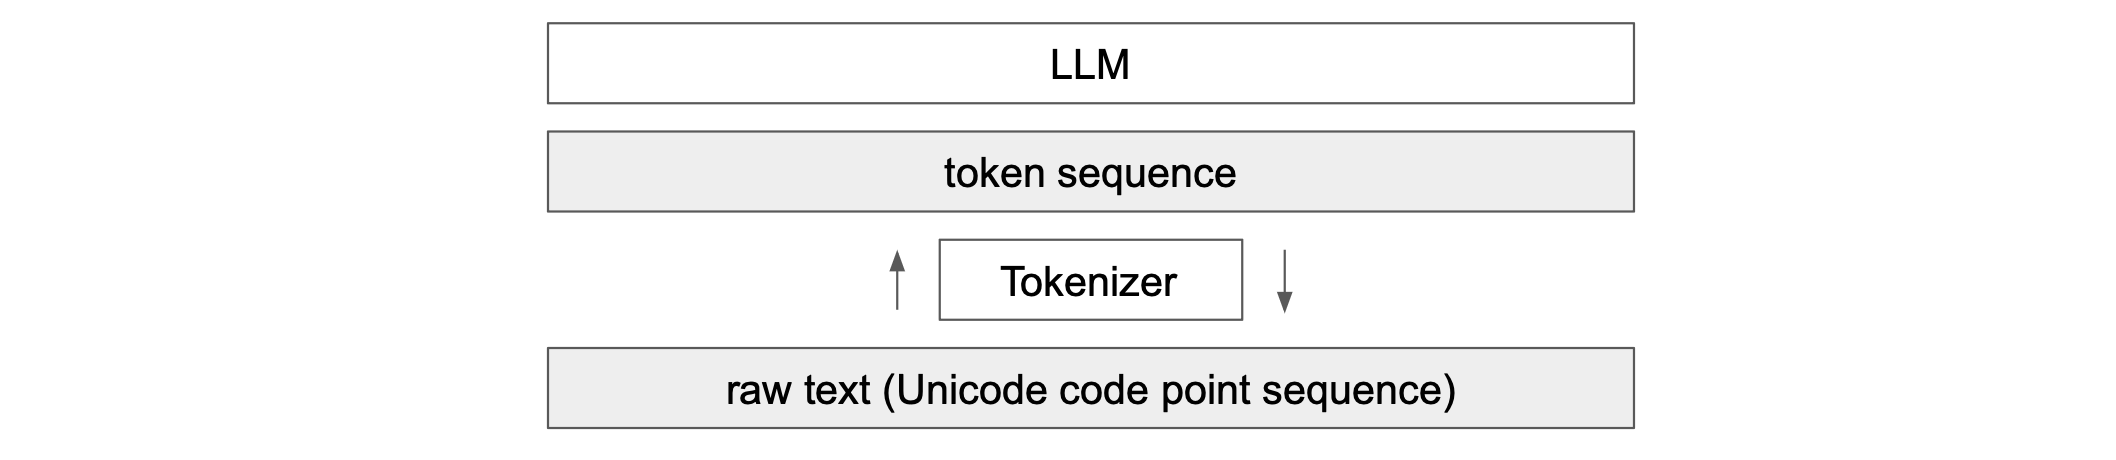

### Decoding <a id="decoding"></a>

Given a sequence of integers in the range [0, vocab_size], what is the text?

In [ ]:
merges

In [ ]:
# Keys are token IDs and values are raw bytes
vocab = {idx: bytes([idx]) for idx in range(256)}
# And now going up the merge tree (adding the merges based on the merge rules)
for (p0, p1), idx in merges.items():
    vocab[idx] = vocab[p0] + vocab[p1]


def decode(ids):
    # Given a list of ints (ids), return Python str
    tokens = b"".join([vocab[idx] for idx in ids])
    # Tokens are raw bytes so we have to decode to a string
    text = tokens.decode("utf-8", errors="replace")
    return text


print(
    decode(
        [
            236,
            149,
            136,
            235,
            133,
            149,
            237,
            149,
            152,
            236,
            132,
            184,
            236,
            154,
            148,
            32,
            240,
            159,
            145,
            139,
            32,
            40,
            104,
            101,
            108,
            108,
            111,
            32,
            105,
            110,
            32,
            75,
            111,
            114,
            101,
            97,
            110,
            33,
            41,
        ]
    )
)

In [ ]:
print(decode([128]))  # this will throw an error if `errors="strict"`

### Encoding <a id="encoding"></a>

Let's implement the other way around: Given a string, what are the tokens?

In [ ]:
def encode(text):
    # Given a str, return a list of ints (tokens)
    tokens = list(text.encode("utf-8"))  # raw bytes
    while len(tokens) >= 2:
        # We only care about the keys (pairs) here not the values (counts)
        stats = get_stats(tokens)
        # Fancy code explained below in detail
        pair = min(stats, key=lambda p: merges.get(p, float("inf")))
        if pair not in merges:
            break  # because nothing to merge
        idx = merges[pair]
        # Perform the merge
        tokens = merge(tokens, pair, idx)

    return tokens


print(encode("hello world!"))

#### Fancy code explanation <a id="fancy"></a>

In the fancy code, we are interested in finding the pair (key) in `stats` with the lowest index in the `merges` dictionary. This is because we want to do all the early merges before we reach the later merges. Let me explain in more detail. Assume the following merges:


```python
print(merges)

{(101, 32): 256,  # we need to merge this first
 (105, 110): 257,
 (115, 32): 258,
 (116, 104): 259,  # then this
 (101, 114): 260,
 (99, 111): 261,
 (116, 32): 262,
 (226, 128): 263,
 (44, 32): 264,
 (97, 110): 265,
 (111, 114): 266,
 (100, 32): 267,
 (97, 114): 268,
 (101, 110): 269,
 (257, 103): 270,
 (261, 100): 271,
 (121, 32): 272,
 (46, 32): 273,
 (97, 108): 274,
 (259, 256): 275}  # before we can do this
```

Before we can merge tokens 259 and 256 to give us token 275, we would have to merge (116, 104) and (101, 32) respectively. This is why we want to do all the early merges first.

To explain the fancy code above in more detail, assume the following example. Imagine we have a text we'd like to encode. We first use the `get_stats` function to get the `stats` dictionary where the keys are consecutive pairs and the values the counts.

```python
text = "hello world!"
tokens = list(text.encode("utf-8"))  # raw bytes
stats = get_stats(tokens)
print(stats)
```

```python
# output
{(104, 101): 1,
 (101, 108): 1,
 (108, 108): 1,
 (108, 111): 1,
 (111, 32): 1,
 (32, 119): 1,
 (119, 111): 1,
 (111, 114): 1,
 (114, 108): 1,
 (108, 100): 1,
 (100, 33): 1}
```

Now how do we find the pair (key) in `stats` that has the lowest index in the `merges` dictionary (remember, we do this to do the early merges first before the later merges)? We could do the following:

1. We can iterate through the pairs (keys) in `stats` (we don't care about the counts here)

2. For each pair, we check if the pair is in the `merges` dictionary

    * If the pair is present, we return the value in the `merges` dictionary
    
    * If the pair is **not** present, we return a arbitarily large value like infinity

3. We append the result in step 2 to a temporary list

4. Once the iteration is completed, we take the index in the temporary list corresponding to the minimum value

5. Using this index, we can get the corresponding pair in the `stats` dictionary

Here's the code in full:

```python
tmp = []
for k in stats.keys():                      # Step 1 -> we don't care about the counts (values) because we are not training the tokenizer now
    value = merges.get(k, float("inf"))     # Step 2
    tmp.append(value)                       # Step 3

idx_of_min = tmp.index(min(tmp))            # Step 4 -> this step ensures we go from first to last in order of merge rule
pair = list(stats.keys())[idx_of_min]       # Step 5
    
print("---")
print(idx_of_min)  # 7
print("---")
print(pair)  # (111, 114) -> we will use this pair (key) to get the new index (value) from the merge rule
```

A less verbose version of the code above is the fancy code:

```python
pair = min(stats, key=lambda p: merges.get(p, float("inf")))  # fancy code of the verbose version above
```


In [ ]:
print(decode(encode("hello world!")))

When we encode and string and decode it back, we'd expect to get the same string back. However, this is not true for all strings. This is because not all token sequences are valid UTF-8 byte streams. Therefore, some of them can't even be decoded.

## Forced splits using regex patterns (GPT Series) <a id="forced_splits"></a>

In GPT-2, they did not only apply the BPE algorithm as naively as we have done so above. Suppose that we have common words like `dog` and it happens frequently in the text. What will happen in our naive BPE implementation is that we will find the word `dog` occurring together with all kinds of punctuations such as `dog.`, `dog!` and `dog?`. It is obvious that the BPE algorithm should be merging these words together when in fact, it is combining semantics with punctuations. This is suboptimal.

To tackle this, the authors enforced that some types of characters should never be merged together. This was what was introduced on top of the BPE algorithm. Let's have a look at a [snippet of their code](https://github.com/openai/gpt-2/blob/9b63575ef42771a015060c964af2c3da4cf7c8ab/src/encoder.py#L53C9-L53C113) which implements this.

In [ ]:
import regex as re


gpt2pat = re.compile(
    r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
)


print(re.findall(gpt2pat, "Hello world how are you"))  # triggers r" ?\p{L}+"

We split our text based on the regex pattern above. More specifically, we are taking our text, and instead of directly encoding it for tokenization, we are first splitting up the text into a list of texts. Every element in the list are then processed independently by the tokenizer and the results of the tokenization are concatenated. 

Roughly speaking, what the above does is that we're ever only finding merges between the elements of the list instead of across words in the entire text. What this means is that the letter "e" in "are" will not be joined with the whitespace in " you" because now they are part of separate elements in the list.

Therefore, using this regex pattern to chunk up the text is one way of enforcing that some merges are not to happen.

**Note:** The above text triggers the `r" ?\p{L}+"` pattern in the regex pattern. What does the pattern mean and why is it important? The pattern means that we will split when we see an optional space followed by any number of letters (a word).

### How do numbers get captured by the regex pattern? <a id="numbers"></a>

In the text below, the word " world123" will trigger both `r" ?\p{L}+"` and `r" ?\p{N}+"`. The word " world" has a space followed by some number of letters and is captured by `r" ?\p{L}+"` whereas the word "123" is captured by `r" ?\p{N}+"` since it does not have a leading space and is followed by some number of numbers.

In [ ]:
print(
    re.findall(gpt2pat, "Hello world123 how are you")
)  # triggers r" ?\p{L}+" and r" ?\p{N}+"

### How do apostrophes get captured by the regex pattern? <a id="apostrophes"></a>

In the text below, the words "Hello've" and " how's" will trigger both `r"'ve"` and `r"'s"`. This means the regex will capture the word "Hello" followed by "'ve" and the word " how" followed by "'s".

In [ ]:
print(re.findall(gpt2pat, "Hello've world how's are you"))  # triggers r"'ve" and r"'s"

It is good to note that these apostrophes are hardcoded and do not work if you use the Unicode apostrophe. This means the word "how’s" will be split into "how", "’" and "s" (which seems nonsensical).

In [ ]:
print(re.findall(gpt2pat, "Hello’ve world how’s are you"))

Another thing to note is that the authors did not add `re.IGNORECASE` which means that apostrophes followed by capital letters will not be captured. See example below. Similar to the case above, it seems like the splitting resulted in nonsensical lone characters.

In [ ]:
print(re.findall(gpt2pat, "Hello'VE world how'S are you"))

### How do punctuations get captured by the regex pattern? <a id="punctuations"></a>

The regex `r" ?[^\s\p{L}\p{N}]+"` signifies that if there is an optional space followed by neither a word, number nor whitespace, then it must be a punctuation. See the example below:

In [ ]:
print(re.findall(gpt2pat, "Hello world how are you!!!???"))

### How do unecessary whitespaces get captured by the regex pattern? <a id="whitespaces"></a>

Finally, the regex `r"\s+(?!\S)|\s+"` captures whitespaces up until but not including the last whitespace. See the example below:

In [ ]:
print(re.findall(gpt2pat, "Hello world how are                     you"))

### Example: Python code <a id="example-python"></a>

You will notice that the example Python code below has many elements that are captured by the regex pattern. That is because the regex pattern is splitting up the text every time a category changes (sort of). Therefore, there will never be any merges between the elements of the list.

You might think that in order to train the tokenizer, OpenAI used the same regex pattern so split up the text into chunks and then ran the BPE algorithm within all the chunks. However, that is not exactly entirely what happened. 

In the code cell below, the whitespaces from the Python code got split up by the regex pattern into elements but these spaces never ended up being merged together. You can confirm this by copying the following example Python code and pasting it into the [Tiktokenizer app](https://tiktokenizer.vercel.app/). You can see that the white spaces ended up having the token ID of 220. This meant that at some point, OpenAI enforced some rule that these spaces would never be merged. 

There are some additional rules on top of simply chunking and running BPE that OpenAI is unclear about. The training code for the BPE was never released by OpenAI, only the inference code. Therefore, we can't be sure how the training was done but it is not as simple as chunking the text and running BPE on the chunks.

In [ ]:
example = """
for i in range(1, 101):
    if i % 3 == 0 and i % 5 == 0:
        print("FizzBuzz")
    elif i % 3 == 0:
        print("Fizz")
    elif i % 5 == 0:
        print("Buzz")
    else:
        print(i)
"""

print(re.findall(gpt2pat, example))

## Tiktoken <a id="tiktoken"></a>

In [ ]:
import tiktoken


# GPT-2 (does not merge spaces)
enc = tiktoken.get_encoding("gpt2")
print(enc.encode("    hello world!!!"))

# GPT-4 (merges spaces)
enc = tiktoken.get_encoding("cl100k_base")
print(enc.encode("    hello world!!!"))

220 are the token ID for whitespaces.

Reference the GPT-2 [encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)
Download the vocab.bpe and encoder.json files.

In [ ]:
# !wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/vocab.bpe
# !wget https://openaipublic.blob.core.windows.net/gpt-2/models/1558M/encoder.json

In [ ]:
import json


with open("encoder.json", "r") as f:
    encoder = json.load(f)  # <--- ~equivalent to our "vocab"

with open("vocab.bpe", "r", encoding="utf-8") as f:
    bpe_data = f.read()

bpe_merges = [
    tuple(merge_str.split()) for merge_str in bpe_data.split("\n")[1:-1]
]  # <---- ~equivalent to our "merges"

## Special Tokens <a id="special-tokens"></a>

In addition to tokens that are coming from the raw bytes and BPE merges, we can also insert all kinds of tokens that will be used to delimit different parts of the data or introduced to create a special structure of the tokens streams.

In [ ]:
len(encoder)

We can see that the `encoder` object from OpenAI's GPT-2 (which is equivalent to our `vocab`) has a length of 50,257. Where does this number come from?

* 256 raw byte tokens
* 50,000 merges
* 1 special token

What is this special token?

```python
print(encoder['<|endoftext|>'])  # 50256
```

This special token is used to delimit documents. When we are creating the training data, we have all these documents which we tokenize and get a stream of tokens. Those tokens only range from 0 to 50,256 and in between those documents, we insert special end-of-text tokens. We are doing this as a signal to the language model that the document has ended and what follows is going to be unrelated to the previous document. The language model has to learn this from data. It needs to learn that this token means that it should treat the previous and next document separate after this special token. In a way, it should "wipe its memory" regarding the previous document because it will not be informative to what comes next in the next document.


**Note:** In our `vocab`, we map integers to raw bytes. If you take a look into the [`encoder.json`](minbpe/notebooks/encoder.json), it maps from strings to integers instead for no amazing reason.

In [ ]:
encoder["<|endoftext|>"]

## Exercise <a id="exercise"></a>

At this point you have everything you need to build your own GPT-4 tokenizer. This is the [exercise progression](https://github.com/karpathy/minbpe/blob/master/exercise.md) you may wish to follow. You'll note that it is part of the [minbpe](https://github.com/karpathy/minbpe) repo, which is the solution to that exercise, and is a cleaned up version of the code above.

In [ ]:
import tiktoken


enc = tiktoken.get_encoding("cl100k_base")  # GPT-4 tokenizer
print(enc.encode("안녕하세요 👋 (hello in Korean!)"))
print(
    enc.decode(enc.encode("안녕하세요 👋 (hello in Korean!)")) == "안녕하세요 👋 (hello in Korean!)"
)
# Match the above for your own tokenizer, and also implement a train() function

In [ ]:
# Your implementation here

## sentencepiece <a id="sentencepiece"></a>

Commonly used because (unlike tiktoken) it can efficiently both train and inference BPE tokenizers. It is used in both Llama and Mistral series.

[`sentencepiece` on Github link](https://github.com/google/sentencepiece).

**The big difference**: `sentencepiece` runs the BPE algorithm on the Unicode code points directly! It then has an option `character_coverage` for what to do with very very rare code points that appear very few times, and it either maps them onto an `UNK` token, or if `byte_fallback` is turned on, it encodes them with UTF-8 into bytes and then encodes the raw bytes instead.

TLDR:

* `tiktoken` takes the Unicode code points, encodes them into bytes using UTF-8 and then performs the BPE algorithm on those bytes
* `sentencepiece` runs the BPE algorithm the Unicode code points and optionally falls back to UTF-8 bytes for rare Unicode code points (rarity is determined by `character_coverage` hyperparameter), which then get translated to byte tokens

(Personally I think the tiktoken way is a lot cleaner...)

In [ ]:
import sentencepiece as spm


# Write a toy.txt file with some random text
with open("tests/toy.txt", "w", encoding="utf-8") as f:
    f.write(
        "SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing."
    )

Docs for `sentencepiece` options:

* [markdown](https://github.com/google/sentencepiece/blob/master/doc/options.md)
* [protobuf](https://github.com/google/sentencepiece/blob/master/src/sentencepiece_model.proto#L193)

There is a ton of options and configurations when using `sentencepiece` and the reason this is so is because it's been around for quite some time and it tries to handle a large diversity of things. Because of this, it has quite a bit of accumulated historical baggage.

**Note:** Many of the configurations however, are irrelevant to the BPE algorithm (e.g. `shrinking_factor` applies to a different training algorithm entirely).

In [ ]:
# Train a sentencepiece model on it
# The settings here are (best effort) those used for training Llama 2
import os


options = dict(
    # input spec
    input="tests/toy.txt",
    input_format="text",
    # output spec
    model_prefix="tok400",  # output filename prefix
    # algorithm spec
    # BPE alg
    model_type="bpe",
    vocab_size=400,
    # normalization
    normalization_rule_name="identity",  # ew, turn off normalization
    remove_extra_whitespaces=False,
    input_sentence_size=200000000,  # max number of training sentences
    max_sentence_length=4192,  # max number of bytes per sentence
    seed_sentencepiece_size=1000000,
    shuffle_input_sentence=True,
    # rare word treatment
    character_coverage=0.99995,
    byte_fallback=True,
    # merge rules
    split_digits=True,
    split_by_unicode_script=True,
    split_by_whitespace=True,
    split_by_number=True,
    max_sentencepiece_length=16,
    add_dummy_prefix=True,
    allow_whitespace_only_pieces=True,
    # special tokens
    unk_id=0,  # the UNK token MUST exist
    bos_id=1,  # the others are optional, set to -1 to turn off
    eos_id=2,
    pad_id=-1,
    # systems
    num_threads=os.cpu_count(),  # use ~all system resources
)

In [ ]:
# Train `sentencepiece`
spm.SentencePieceTrainer.train(**options)

When we train `sentencepiece` on our text, it will generate the `tok400.model` and `tok400.vocab` files. We can then load the `tok400.model` file and inspect the vocabulary. 

**Note*:* We trained a `vocab_size` of 400 which is why we have 400 tokens in the vocabulary.

Below are the individual tokens `sentencepiece` will create. In the beginning, we can see the `unk` token with the ID 0. Then we have the beginning of sequence (`bos`) and end of sequence (`eos`) with IDs 1 and 2 respectively. Because we set the `pad_id` (see configuration above) to -1, we don't have a padding token.

Following the special tokens, we have the 256 byte tokens and their IDs. After the byte tokens, we have the merges (i.e. the parent nodes in the merges) and their IDs. Finally, after the merges, come the individual tokens (the Unicode code point tokens if you will) and their IDs.

This is the ordering with which `sentencepiece` represents its vocabularies. It starts with special tokens, byte tokens, merge tokens, and then individual Unicode code point (raw) tokens. All these raw Unicode code point tokens are the ones it encountered in the [training set](../tests/toy.txt). These raw tokens are not considered extremely rare as determined by `character_coverage` in the configuration. If they were, then they will not be included in the vocabulary.

In [ ]:
sp = spm.SentencePieceProcessor()
sp.load("tok400.model")
vocab = [[sp.id_to_piece(idx), idx] for idx in range(sp.get_piece_size())]
vocab

### `byte_fallback` <a id="byte-fallback"></a>

In [ ]:
ids = sp.encode("hello 안녕하세요")
print(ids)

The Korean characters are not part of the [training set](../tests/toy.txt) so `sentencepiece` is encountering code points that it has not seen during training time and those code points do not have a token associated to them. Now suddenly, these Korean characters are `unk` tokens but since `byte_fallback` is enabled to `True`, `sentencepiece` instead falls back to bytes. So instead, it takes the Korean characters, encodes it using UTF-8 into raw bytes and uses the byte tokens in the vocabulary to represent those raw bytes.

**Note:** If `byte_fallback` is set to `False` then `sentencepiece` will not fall back to bytes and there will be more merge tokens since now the vocabulary has more space. Then now, if you encode the Korean characters, it simply becomes a 0 (i.e. `unk` token). It is important to note that these 0's will be fed into your language model. So what is a language model supposed to do when all kinds of different things that are unrecognized because they are rare just end up mapping to `unk`s? This definitely isn't the property that you want.

### `add_dummy_prefix` <a id="add-dummy-prefix"></a>

In [ ]:
print([sp.id_to_piece(idx) for idx in ids])

Another thing to note when decoding the individual tokens is that the spaces end up being a bold underline (or underscore). More interestingly than that is that there is a bold underscore at the start of a word. That comes from the argument in the configuration called `add_dummy_prefix` which is set to `True`. In [protobuf](https://github.com/google/sentencepiece/blob/52a7f156a494ce288e357f9c4a3b1f955fc1014d/src/sentencepiece_model.proto#L256C3-L256C55) documentation, it describes the purpose of this argument. It adds dummy whitespace at the beginning of text in order to treat "world" in "world" and "hello world" in the same way.

If you head back to the [Tiktokenizer app](https://tiktokenizer.vercel.app/), make sure `cl100k_base` (i.e. tokenizer for GPT-4) is selected. Then, if you type "world" and "hello world" into the text box, you will see that the word "world" by itself, has a different token ID than the word "world" in "hello world". The language model then has to learn from data that thet are actually kind of a very similar concept. Therefore, words in the beginning of sentences and words in the middle of sentences actually look completely different to a language model which uses `tiktoken` (but has been learned by the lanuage model that they are roughly the same).

Therefore, this `add_dummy_prefix` is trying to fight this. The way that it works is that it basically adds a dummy prefix. As a part of preprocessing, it will take the string and it will add a whitespace at the beginning of the sentence in an effort to make words appearing in different parts of the sentences the same.

### Llama 2 tokenizer proto <a id="llama-2-tokenizer-proto"></a>

If you'd like to export the raw protocol buffer for the `tokenizer.model` released by meta, this is a [helpful issue](https://github.com/google/sentencepiece/issues/121). And this is the result:

```
normalizer_spec {
  name: "identity"
  precompiled_charsmap: ""
  add_dummy_prefix: true
  remove_extra_whitespaces: false
  normalization_rule_tsv: ""
}

trainer_spec {
  input: "/large_experiments/theorem/datasets/MERGED/all.test1.merged"
  model_prefix: "spm_model_32k_200M_charcov099995_allowWSO__v2"
  model_type: BPE
  vocab_size: 32000
  self_test_sample_size: 0
  input_format: "text"
  character_coverage: 0.99995
  input_sentence_size: 200000000
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  num_threads: 80
  num_sub_iterations: 2
  max_sentence_length: 4192
  shuffle_input_sentence: true
  max_sentencepiece_length: 16
  split_by_unicode_script: true
  split_by_whitespace: true
  split_by_number: true
  treat_whitespace_as_suffix: false
  split_digits: true
  allow_whitespace_only_pieces: true
  vocabulary_output_piece_score: true
  hard_vocab_limit: true
  use_all_vocab: false
  byte_fallback: true
  required_chars: ""
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_surface: " \342\201\207 "
  unk_piece: "<unk>"
  bos_piece: "<s>"
  eos_piece: "</s>"
  pad_piece: "<pad>"
  train_extremely_large_corpus: false
  enable_differential_privacy: false
  differential_privacy_noise_level: 0.0
  differential_privacy_clipping_threshold: 0
}
```

### `vocab_size` <a id="vocab-size"></a>

* **Question:** What should be `vocab_size`?
* **Question:** How can I increase `vocab_size`?
* **Answer:** Let's see. Reminder: `gpt.py` from before.

`vocab_size` in `gpt.py` does not come up much in most of the layers. The only two places that it comes up to is in exactly two places:

1. `nn.Embedding` 
    * As `vocab_size` grows, the embedding table also increases in size

2. `nn.Linear` 
    * Linear layer used at the end of the Transformer and is used to produce the logits which will become the probabilities for the next token in the sequence

```python
# each token directly reads off the logits for the next token from a lookup table
self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
...
self.lm_head = nn.Linear(n_embd, vocab_size)
...
# forward method
logits = self.lm_head(x)
```

Intuitively, we're trying to produce a probability for every dingle token that might come next at every point in time of that Transformer and if we have more and more tokens, we need to produce more and more probabilties. So, every additional token is going to introduce an additional dot product that we have to do in the linear layer that we have to do for this final layer in the Transformer. 

Why can't the `vocab_size` be very large? 

1. The embedding table and linear layer are going to grow and become computationally expensive

2. A large `vocab_size` would mean more parameters and these additional parameters could be undertrained

    * Intuitively, if you have a very large vocabulary size (say, a milllion tokens), then every one of these tokens will come up more and more rarely in the training data because there's a lot more other tokens all over the place. So, we will see fewer and fewer examples of each individual token and you might be worried that the vectors associated with every token will be undertrained as a result because they just don't come up too often and they don't participate in the forward and backward pass.

3. In addition, as `vocab_size` increases, the sequences will start shrinking a lot

    * This has a nice property where the model will be able to attend to more and more text but you might now be worried that two large chunks are being squished into single tokens. This might cause the model to not have as much "time to think" per some number of characters in the text. Basically, we are squishing too mcuh information into a single token and the forward pass of the Transformer is not sufficient to actually process that information appropriately.

These are some of the considerations to think about when setting the `vocab_size` which is mostly an empirical hyperparameter. In state-of-the-art architectures today, this is usually in the high 10,000 or 100,000.

## Extension of `vocab_size` <a id="extension"></a>

What if we want to take a pre-trained model and extend the `vocab_size`? This is done fairly commonly. For example, when fine-tuning for ChatGPT, a lot more new special tokens get introduced on top of the base model to maintain the metadata and all the structure of conversation objects between a user and an assistant. You might also try to throw in special tokens for using the browser or other tools. It is very temping to add all kinds of special tokens for all kinds of special functionality. 

So if you want to be adding tokens, that's totally fine. All we have to do is:

1. Resize the embedding layer (add rows)

2. Initialize these parameters from scratch to be small random numbers and extend the weight inside the final linear layer where we can start making dot products with these associated parameters to bascially calculate the probabilities for these new tokens

Both if these are just a resizing operation which is a very mild model surgery and can be done fairly easily and it's quite common. Basically you would freeze the base model, introduce these new parameters and then you only train these new parameters to introduce new tokens into the architecture. You can choose to freeze or train arbitrary parts of it and it's totally up to you.

## [Learning to Compress Prompts with Gist Tokens](https://arxiv.org/pdf/2304.08467.pdf) <a id="gist-tokens"></a>

There exists an entire design space of applications in terms of introducing new tokens into a vocabulary that go way beyong just adding special tokens and special new functionality. One example is the paper on [_Learning to Compress Prompts with Gist Tokens_](https://arxiv.org/pdf/2304.08467.pdf). This is a paper on learning to compress prompts with what they called _gist_ tokens. The rough idea is suppose that you're using language models in a setting that requires very long prompts. These long prompts slow everything down because you have to encode them and then you ahve to use them and then you're attending over them and it's just expensive to have very large prompts. So instead what they did in this paper was they introduced new tokens — basically imagine having a few new tokens and you put them in a sequence — and then trained the model by distillation (entire model is kept frozen and only the representations or embeddings of the new tokens are trained). The new tokens are optimized over such that the behaviour of the language model is identical to the model that has a very long prompt that works for you. SO it's a compression technique of compressing that very long prompt into those few new gist tokens. So you can train this and at test time, you can discard your old prompt and just swap in those tokens and they can sort of "stand in" for the very long prompt (that was discarded) and have an almost identical performance. This is one technique and a class of [parameter efficient fune-tuning (PEFT)](https://huggingface.co/docs/peft/index) techniques where most of the model is basically fixed and there's no training of the model weights and there's no training of new parameters like in [_LoRA: Low-Rank Adaptation of Large Languauge Models_](https://arxiv.org/pdf/2106.09685.pdf). The parameters that you're training are now just token embeddings.

## Multimodality <a id="multimodality"></a>

Recently, there's been a lot of momentum in how you could actually construct Transformers that can simulataneously process not just text, but also images, audio, and videos. How do you feed in all these modalities and potentially predict these modalities from a Transformer? Do you have to change the architecture in some fundamental way? What most people are converging towards is that you're not changing the architecture. You stick with the transformer and you just kind of tokenize your input domains and then call it a day and pretend it's just text tokens and doing everything else in an identical manner.

**Examples**
1. [Taming Transformers for High-Resolution Image Synthesis](https://compvis.github.io/taming-transformers/)
2. [Sora](https://openai.com/sora)


## Revisiting and explaining the quirks of LLM tokenization <a id="revisiting-and-explaining-the-quirks-of-llm-tokenization"></a>

### Why can't LLM spell words? <a id="why-cant-llm-spell-words"></a>

Why can't LLM spell or do other spelling related tasks well? 

So fundamentally this is because, as we saw, these characters are chunked up into tokens and some of these tokens are actually fairly long. If you were to look at GPT-4's vocabulary, one of the longest tokens is ".DefaultCellStyle" which turns out to be a single individual token. So that's a lot of characters for a single token. Therefore, the suspicion would be that the model should not be very good at tasks related to spelling of the word ".DefaultCellStyle".

#### **Examples:**

**User:** `How many letters "l" are there in ".DefaultCellStyle"`

**ChatGPT:** `The word ".DefaultCellStyle" has **three** letters "l"`

---

**User:** `Reverse the string: ".DefaultCellStyle". Print it as a comma-separated list of characters (no tools)`

**ChatGPT:** `"t", "l", "u", "a", "F", "t", "l", "u", "a", "e", "D", ".", "y","t", "l", "e", "S", "."`
 
---

**User:** `Reverse the string: ".DefaultCellStyle". Take the following approach. First print out every single character seaprated by spaces. Then as a step 2 print out all the characters backwards, again separated by spaces. (no tools)`

**ChatGPT:** `First, let's print out every single character of the string ".DefaultCellStyle" separated by spaces:`
```python
. D e f a u l t C e l l S t y l e
```
`Now, let's reverse the string and print out all the characters backwards, again separated by spaces:`
```python
e l y t S l l e C t l u a f e D .
````

It is interesting to note that ChatGPT was able to get the last task right. It was able to spell out the word letter by letter correctly and successfully reverse the string. But somehow, it can't reverse the word directly. This is most likely because when the word is broken up into individual characters, it is now much easier for the model to "see" these individual tokens and successfully reverse them.  

### Why is LLM worse at non-English languages (e.g. Japanese)? <a id="why-is-llm-worse-at-non-english-languages"></a>

It is not only that the language model sees less non-English data during training of the model parameters but also the tokenizer is not sufficiently trained on non-English data. For example, "Hello how are you?" is five tokens and "안녕하세요. 어떻게 지내세요" is 15 tokens. This is a three times blow up!

"안녕하세요" which simply means "hello" in Korean ends up being three tokens which is surprising looking at how it's a very common phrase. The English word "hello" is only a single token! So basically everything is more bloated and diffuse and that is partly the reason the model works worse on other languages. 

### Why is LLM bad at simple arithmetic? <a id="why-is-llm-bad-at-simple-arithmetic"></a>

That has to do with the tokenization of numbers. For example, you will notice that for addition, it is an algorithm that works on the character level. We would add the ones, then the tens, followed by the hundreds and thousands etc. You have to refer to specific parts of these digits. However, these numbers are represented completely arbitrarily based on whatever happened to merge or not merge during the tokenization process.

There is an entire [blog post](https://www.beren.io/2023-02-04-Integer-tokenization-is-insane/) about this and it is quite good. The author basically systematically explores the tokenization of numbers. For example for four digit numbers, you can examine whether it is a single token, or tokens that is a 1-3, or a 2-2 or 3-1 combination. So all the different numbers are all the different combinations and you can imagine this is all completely arbitary and the model sometimes sees a token for all four digits, sometimes for three, two or one. This is definitely a headwind, if you will, for language models and is not ideal. 

**Note:** This could be why at Meta, when Llama 2 was trained, `sentencepiece` was used to split up all the digits. This is partly to improve simple arthmetic performance.

### Why did GPT-2 have more than necessary trouble coding in Python? <a id="why-did-gpt-2-have-more-than-necessary-trouble-coding-in-python"></a>

Again, this is partly a modeling issue on the architecture, the dataset and the strength of the model but it's also partially a tokenization issue. Because as we saw [previously](#example-python) in the simple Python example, the encoding efficiency of the tokenizer for handling spaces in Python is terrible (every single space is an individual token) and this dramatically reduces the context length that the model can attend to. That's almost like a tokenization bug for GPT-2 which was later fixed in GPT-4.

### Why did my LLM abruptly halt when it sees the string "<|endoftext|>"? <a id="why-did-my-llm-abruptly-halt-when-it-sees-the-string-end-of-text"></a>

#### **Example:**

**User:** `Print the string <|endoftext|>`

**ChatGPT:** `Could you please specify the string you'd like to print?`

**User:** `Echo this exact string back to me: <|endoftext|>`

**ChatGPT:** `It seems like there might have been an issue with the input, as I didn't receive a string to echo back. Could you please provide the string again?`

**User:** `"<|endoftext|>" is the string`

**ChatGPT:** `Here's the string you asked to be echoed back: ""`

From the example above, it is obvious that something is breaking with respect to then handling of the special token and it is unclear what OpenAI is doing under the hood here, and whether they are potentially parsing the string "<|endoftext|>" as an actual token instead of this just being a string. It might be that when `.encode` is called, the `allowed_special` argument is passed and is allowing "<|endoftext|>" as a special character in the user prompt. However, the user prompt is sort of a attacker controlled text so you would hope that OpenAI don't really parse or use special tokens from the user's prompt but there's something definitely going wrong here. So your knowledge of these special tokens ends up being in an attack surface potentially and if you'd like to confuse LLMs then you can try to give them some special tokens to see if they are breaking by chance.

### What is this weird warning I get about a "trailing whitespace"? <a id="what-is-this-weird-warning-i-get-about-a-trailing-whitespace"></a>

This issue can be illustrated with `gpt-3.5-turbo-instruct` which is a completion model (not a chat model). Imagine giving it a tagline as follows:

```
Here is a tag line for an ice cream shop:
```
_"Scoops of happiness in every cone!"_

That's a great tag line! Now, suppose you add a whitespace in front of your prompt instead of a breakline. You would get a warning as follows:

```
Warning: Your text ends in a trailing space, which causes worse performance due to how the API splits text into tokens.
```

What is happending here? Suppose you found the completion in the training document somewhere on the internet and the LLM trained on this data. As an exmaple:

```
Here is a tag line for an ice cream shop: Oh yeah
```

Notice how there is a space after the colon. Spaces are always a prefix to tokens in GPT. Therefore, it is not just an "Oh" token but an " Oh" token with a whitespace for prefix. Therefore, what's happening above is that when you did not add a whitespace after the colon, the model was able to sample an " Oh" token (with a whitespace prefix). However, when you add a whitespace at the end of your prompt, it gets tokenized into its own token which would have otherwise been a part of the tag line. Suddenly, this is an out-of-distribution for the model because the whitespace should have been a part of the next token and the model has seen very very little data of actual whitespace by itself.

Going back to our ".DefaultCellStyle" example from [above](#why-cant-llm-spell-words), it is almost guaranteed that the model has never seen ".DefaultCellSty" (without the last two letters) in its training set. It is almost definite that it sees the word as a single group. Therefore, if you took ".DefaultCellSty" as a prompt to the `gpt-3.5-turbo-instruct` completion model and tried to complete from it, you would get a big error:

```
The model predicted a completion that begins with a stop sequence, resulting in no output. Consider adjusting your prompt or stop sequences.
```

What likely happened here was that the model immediately emitted the end of text token (it basically predicted ths top sequence immediately) and resulted in no completion and the subsequent warning. We are off the data distribution and the model is predicting totally arbitrary things.

### Why the LLM break if I ask it about "SolidGoldMagikarp"? <a id="why-the-llm-break-if-i-ask-it-about-solidgoldmagikarp"></a>

It comes from this [blog post](https://www.lesswrong.com/posts/aPeJE8bSo6rAFoLqg/solidgoldmagikarp-plus-prompt-generation). What the author did was he went to the token embeddings table and clustered the tokens based on their embedding representation and he noticed that there was this cluster of tokens that looked really strange. So what are these tokens and where did they even come from? What's even "SolidGoldMagikarp"? If you ask the LLM about the weird words in this cluster, you would get back a variety of totally broken LLM behaviour. So basically there are a bunch of trigger words and if you ask the model of these trigger words or you just include them in your prompt, the model goes haywire and has all kinds of really strange behaviours. 

What is happening here?

This again comes down to tokenization. What's happening here is that "SolidGoldMagikarp" if you actually dig into it is a Reddit user (i.e. `u/SolidGoldMagikarp`). What is thought to have happened is that the tokenization dataset is very different from the training dataset for the actual language model. So in the tokenization dataset, there was potentially a ton of Reddit data where the user "SolidGoldMagikarp" was mentioned in the comments. Because the user "SolidGoldMagikarp" was a person who posted a lot, this would be a string that occurs many times in the tokenization dataset. Because it appears many times, these tokens would end up getting merged into the single individual token for that single Reddit user. So they would have a dedicated token for that user in the 50,000 vocabulary in GPT-2 that is devoted to that Reddit user. Then what happens is when you train the model, this data from Reddit was not present in the training dataset and therefore, the token "SolidGoldMagikarp" never appears and never gets activated. It's initialized at random in the beginning of optimization, then you have forward and backward passes and updates the model and this token is never updated in the embedding table. That row vector never gets sampled and it never gets used so it never gets trained. It's completely untrained and this is like an unallocated memory in a typical binary program written in C. Then at test time, when you invoke this token, then you're basically "plucking" out a row in the embedding table that is completely untrained and feeds into the Transformer and creates various undefined behaviours.

### Why should I prefer to use YAML over JSON with LLMs? <a id="why-should-i-prefer-to-use-yaml-over-json-with-llms"></a>

```json
{
  "product": {
    "type": "T-Shirt",
    "price": 20.0,
    "sizes": ["S", "M", "L"],
    "reviews": [
      {
        "username": "userl",
        "rating": 4,
        "created_at": "2023-04-19T12:30:002"
      },
      { "username": "user2", "rating": 5, "created_at": "2023-05-02T15:00:00Z" }
    ]
  }
}
```

```yaml
product:
    type: T-Shirt
    price: 20.00
    sizes:
        - S
        - M
        - L
    reviews:
        - username: user1
          rating: 4
          created _at: "2023-04-19T12:30:002"
        - username: user2
          rating: 5
          created_at: "2023-05-02T15:00:00Z"
```

Different kinds of formats and different kinds of representations and different languages and so on might be more or less efficient with GPT tokenizers or any tokenizers for that matter. For example, JSON is really dense in tokens and YAML is a lot more efficient in tokens. In the above JSON and YAML formats, JSON has 116 tokens while YAML has 99 tokens — so quite a bit of improvement. 

In the token economy, users are paying per token in many ways and you're paying in context length and dollar amount for the cost of processing all these kinds of structured data. Therefore, YAMLs is preferred over JSONs. In general the tokenization densities is something that you have to sort of care about and worry about at all times and try to find efficient encoding schemes and spend a lot of time in tokenizer and measure the different token efficiencies of different formats and settings and so on.